In [1]:
# the enviroment file is with this file
import joblib
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from pandas import DataFrame
from matplotlib import pyplot
from numpy import unique
from numpy import where
from decimal import Decimal

In [2]:
victim_model = joblib.load("victim_kmeans_model.pkl")

In [3]:
df = pd.read_csv('processed_data.csv')
real_data = df.iloc[:,:5].astype("float64")
real_data = real_data.to_numpy()
real_labels = victim_model.predict(real_data)

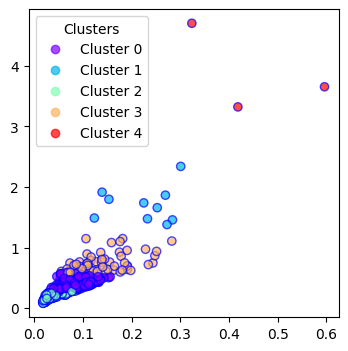

In [4]:
plt.figure(figsize=(4,4))
scatter = plt.scatter(real_data[:,0], real_data[:,1], c=real_labels, cmap='rainbow', alpha=0.7, edgecolors='b')
legend_labels = [f'Cluster {i}' for i in range(len(victim_model.cluster_centers_))]
plt.legend(handles=scatter.legend_elements()[0], title='Clusters', labels=legend_labels)
# Save the figure as a PDF
plt.savefig('original_cluster.pdf', format='pdf')
plt.show()

In [5]:
df['cluster'] = real_labels

In [6]:
df10 = pd.DataFrame(df.loc[df['cluster']==0])
# print(df10)
df11 = pd.DataFrame(df.loc[df['cluster'] == 1])
# print(df11)
df12 = pd.DataFrame(df.loc[df['cluster'] == 2])
# print(df12)
df13 = pd.DataFrame(df.loc[df['cluster'] == 3])
# print(df13)
df14 = pd.DataFrame(df.loc[df['cluster'] == 4])
# print(df14)
frequency = df10.label.value_counts()
print(frequency)
frequency = df11.label.value_counts()
print(frequency)
frequency = df12.label.value_counts()
print(frequency)
frequency = df13.label.value_counts()
print(frequency)
frequency = df14.label.value_counts()
print(frequency)

1    183
0     77
Name: label, dtype: int64
1    6
0    4
Name: label, dtype: int64
0    182
1     53
Name: label, dtype: int64
1    45
0    23
Name: label, dtype: int64
0    2
1    1
Name: label, dtype: int64


In [7]:
# Define a function that returns all samples that belong to the cluster selected
def get_samples_with_cluster(model, original_samples_X, target_cluster):
    return [original_samples_X[i] for i in range(len(original_samples_X)) if model.predict([original_samples_X[i]]) == target_cluster]

# Define a function that retrieves the samples that are clustered in target_cluster
def get_samples_clustered_as(target_cluster, from_data_samples, data_labels):
    if(len(from_data_samples) != len(data_labels)):
        return None
    samples = []
    sample_indexes = []
    for i in range(len(data_labels)):
        if(data_labels[i] == target_cluster):
            samples.append(from_data_samples[i])
            sample_indexes.append(i)
    return samples,sample_indexes

def get_of_decimal_points(number):
    d = Decimal(f"{number}")
    return (d.as_tuple().exponent * -1) + 1

def get_smallest_distances(distances):
    smallest_distances = []
    for index, item in enumerate(distances):
        closest_data_point_index = np.argmin(item)
        distance = item[closest_data_point_index]
        smallest_distances.append([index, closest_data_point_index, distance])
    return smallest_distances

def get_k_smallest_datapoints(distances,k):
    an_array = np.array(get_smallest_distances(distances))
    smallest_indices = np.argsort(an_array[:,2], kind='stable')
    if k < len(an_array):
        k_smallest_datapoints = [[an_array[smallest_indices[i],0],an_array[smallest_indices[i],1]] for i in range(k)]
    else:
        k_smallest_datapoints = [[an_array[smallest_indices[i],0],an_array[smallest_indices[i],1]] for i in range(len(an_array))]
    return k_smallest_datapoints
    

# Define a function that returns a sorted array containing the indices of the k nearest neighbors to the target Cluster Center using Euclidean Distance (l2)
def euclidean_distances_from_target_cluster_center(target_cluster_data_points, target_samples, k):
    distances = euclidean_distances(target_samples, target_cluster_data_points)
    # distances = np.argsort(distances[0], kind='stable')
    k_smallest_datapoints = get_k_smallest_datapoints(distances,k)
    return k_smallest_datapoints

# Define a function that returns a sorted array containing the indices of the nearest neighbors to the sample from the target samples using Manhatten Distance (l1)
def manhatten_distances_from_target_cluster_center(target_cluster_data_points, target_samples, k):
    distances = manhattan_distances(target_samples, target_cluster_data_points)
    # distances = np.argsort(distances[0], kind='stable')
    k_smallest_datapoints = get_k_smallest_datapoints(distances,k)
    return k_smallest_datapoints

# Define a function that returns the distance between two samples
def get_distance_between(sample_a, sample_b):
    return np.linalg.norm((np.array(sample_a) - np.array(sample_b)), ord=1)

# Define a function that perturbs the sample x by updating its features step-by-step toward the target cluster center features in the hope of having it clustered as blonging to the target cluster by the victim model
def perturbe_sample_step_by_step_towards_target_cluster_center_modified(model, sample_x, target_cluster_datapoint, target_cluster, max_perturbation, step_size, step_size_precision):
    adversarial_sample_x = sample_x.copy()

    while get_distance_between(adversarial_sample_x, sample_x) <= max_perturbation:
        for i in range(len(target_cluster_datapoint)):
            gap = round(target_cluster_datapoint[i] - adversarial_sample_x[i], step_size_precision)
            if gap == 0:
                continue
            elif gap > 0:
                adversarial_sample_x[i] += step_size
            else:
                adversarial_sample_x[i] -= step_size
            
            if model.predict([adversarial_sample_x])[0] == target_cluster:
                    print(f"We have successfully perturbed the sample {sample_x} into {adversarial_sample_x} with perturbation of {get_distance_between(adversarial_sample_x, sample_x)}")
                    return adversarial_sample_x
            elif get_distance_between(adversarial_sample_x, sample_x) > max_perturbation or get_distance_between(adversarial_sample_x, target_cluster_datapoint) < step_size:
                    continue
    # return a none if no perturbation was found that satisfys our conditions
    return []

# Define a function that takes a model and implements an attack using sample data and which cluster (from_cluster) to be misclassified as which class (target_class)
def perturbe_samples_with_class(model, from_cluster,from_cluster_datapoints, from_cluster_datapoints_indexes, target_cluster,target_cluster_datapoints,closest_k_instances_to_target_cluster, max_perturbation, step_size, save_file):

    # result to be returned that show the previous state of the sample data, the perturbed adversarial samples, the predicted class for the sample data, and the predicted class for the peturbed adversarial sample
    result = []

    step_size_precision = get_of_decimal_points(step_size)

    if save_file:
#         perturbed_data_set = (real_data.copy()).tolist()  # including the original
        perturbed_data_set = [] # just the peturbed samples
#           perturbed_data_set = real_data.copy()
    else:
        perturbed_data_set = None

    # perturbing all sample data (from_cluster_datapoints)
    for i in range(len(closest_k_instances_to_target_cluster)):

        current_sample_instance_index = int(closest_k_instances_to_target_cluster[i,0])
        current_sample_instance = from_cluster_datapoints[current_sample_instance_index]

        closest_target_cluster_datapoint_index = int(closest_k_instances_to_target_cluster[i,1])
        closest_target_cluster_datapoint = target_cluster_datapoints[closest_target_cluster_datapoint_index]

        adversarial_sample_x = perturbe_sample_step_by_step_towards_target_cluster_center_modified(
            model, current_sample_instance, closest_target_cluster_datapoint, target_cluster, max_perturbation,step_size, step_size_precision)
        
        if len(adversarial_sample_x) > 0:
            result_for_sample = [current_sample_instance, adversarial_sample_x, from_cluster, model.predict([adversarial_sample_x])]
            if save_file:
#                 sample_x_index_in_dataset = from_cluster_datapoints_indexes[current_sample_instance_index]
                perturbed_data_set.append(adversarial_sample_x)
        else:
            result_for_sample = [current_sample_instance, adversarial_sample_x, from_cluster, adversarial_sample_x]

        result.append(result_for_sample)

    # returning the result of the perturbation (The actual Attack)
    return result, perturbed_data_set

In [17]:
from pandas import DataFrame
from numpy import unique, where
import matplotlib.pyplot as plt

def plot_result(adversarial_attack_results):
    adversarial_attack_results = [x for x in adversarial_attack_results if len(x[3]) > 0]
    if len(adversarial_attack_results) > 0:
        transformed_results = DataFrame(adversarial_attack_results)
        samples_before = transformed_results[0]
        samples_after = transformed_results[1]

        ideal_model = victim_model
        ideal_yhat = ideal_model.predict(real_data)
        clusters = unique(ideal_yhat)

        plt.figure(figsize=(10,10))

        # Scatter plot with legend and cluster centers
        for cluster in clusters:
            row_ix = where(ideal_yhat == cluster)
            # create scatter of these samples
            plt.scatter(real_data[row_ix, 0], real_data[row_ix, 1], s=10, label=f'Cluster {cluster}')

        plt.scatter([x[0] for x in samples_before], [x[1] for x in samples_before], marker='+', s=100, label='Samples Before')
        plt.scatter([x[0] for x in samples_after], [x[1] for x in samples_after], marker='x', s=100, label='Samples After')

        for cluster_center in ideal_model.cluster_centers_:
            plt.scatter(cluster_center[0], cluster_center[1], s=20, label='Cluster Center')

        # Increase font size
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('SD', fontsize=20)
        plt.ylabel('Range', fontsize=20)
#         plt.title('Adversarial Attack Results', fontsize=18)
        plt.legend(fontsize=18)
        plt.savefig('after_attack_cluster.pdf', format='pdf')
        plt.show()
    else:
        print("No samples were perturbed.")


In [12]:
# Performing an Adversarial Attack on the victim_model by perturbing all data that are classified as class "3" into being classified as Class "1"
attack_successes = {}

#Attack Parameters
from_cluster = 0    # The cluster we want the to perturb its data
target_cluster = 2 # The cluster we want the data to be clustered as
step_size = 0.0010  # The amount of perturbation to be performed in one step (Epsilon)
k = 100             # The number of closest data points in from_cluster to target cluster
save_file = True   # Whether to save the perturbed data in a file

In [13]:
# get all samples classified as the from_class and their indexes if save_file is True
if save_file:
    from_cluster_datapoints, from_cluster_datapoints_indexes = get_samples_clustered_as(from_cluster,real_data,real_labels)
else:
    from_cluster_datapoints, _ = get_samples_clustered_as(from_cluster,real_data,real_labels)

# get all datapoints clustered as target_cluster
target_cluster_datapoints,_ = get_samples_clustered_as(target_cluster,real_data,real_labels)

# get the target cluster center coordinates
target_cluster_center = victim_model.cluster_centers_[target_cluster]

# we include the cluster center as one of the points to be targeted
target_cluster_datapoints.append(target_cluster_center)

# get the top 100 instances closest to dicision boundary
closest_k_instances_to_target_cluster = np.array(euclidean_distances_from_target_cluster_center(
    target_cluster_datapoints, from_cluster_datapoints, k))

We have successfully perturbed the sample [5.30899480e-02 3.08077220e-01 5.08335300e-03 2.84000000e-05
 9.88572377e-01] into [5.30899480e-02 3.02077220e-01 6.08335300e-03 2.84000000e-05
 9.87572377e-01] with perturbation of 0.008000000000000007
We have successfully perturbed the sample [6.32184020e-02 3.06668143e-01 7.19309400e-03 4.02000000e-05
 9.89619828e-01] into [6.42184020e-02 2.99668143e-01 5.19309400e-03 4.02000000e-05
 9.93619828e-01] with perturbation of 0.01400000000000001
We have successfully perturbed the sample [7.32620940e-02 3.03001216e-01 5.07702800e-03 2.84000000e-05
 9.96076448e-01] into [6.82620940e-02 2.98001216e-01 5.07702800e-03 2.84000000e-05
 9.96076448e-01] with perturbation of 0.010000000000000009
We have successfully perturbed the sample [6.58929370e-02 3.09608990e-01 7.23494400e-03 4.04000000e-05
 9.90457625e-01] into [6.38929370e-02 2.99608990e-01 6.23494400e-03 4.04000000e-05
 9.93457625e-01] with perturbation of 0.016000000000000014
We have successfully 

We have successfully perturbed the sample [6.96591670e-02 3.32251770e-01 7.08471400e-03 3.96000000e-05
 9.91825771e-01] into [6.26591670e-02 3.00251770e-01 5.08471400e-03 3.96000000e-05
 9.93825771e-01] with perturbation of 0.04300000000000004
We have successfully perturbed the sample [6.69095980e-02 3.33513115e-01 7.23447800e-03 4.04000000e-05
 9.90927444e-01] into [6.29095980e-02 2.99513115e-01 6.23447800e-03 4.04000000e-05
 9.93927444e-01] with perturbation of 0.04200000000000004
We have successfully perturbed the sample [5.21077170e-02 3.34432801e-01 7.25544400e-03 4.05000000e-05
 9.84594357e-01] into [5.21077170e-02 3.02432801e-01 6.25544400e-03 4.05000000e-05
 9.87594357e-01] with perturbation of 0.03600000000000003
We have successfully perturbed the sample [6.24680440e-02 3.33574972e-01 7.34073300e-03 4.10000000e-05
 9.89210171e-01] into [6.34680440e-02 2.99574972e-01 6.34073300e-03 4.10000000e-05
 9.94210171e-01] with perturbation of 0.041000000000000036
We have successfully pe

We have successfully perturbed the sample [7.33924520e-02 3.62133217e-01 7.81918200e-03 4.37000000e-05
 9.89562875e-01] into [6.33924520e-02 3.00133217e-01 4.81918200e-03 4.37000000e-05
 9.94562875e-01] with perturbation of 0.08000000000000007
We have successfully perturbed the sample [1.04505400e-01 3.50096887e-01 3.03004900e-03 1.69000000e-05
 9.99142978e-01] into [6.25054000e-02 3.00096887e-01 6.03004900e-03 1.69000000e-05
 9.94142978e-01] with perturbation of 0.10000000000000009
We have successfully perturbed the sample [9.70584270e-02 3.57092157e-01 3.34760200e-03 1.87000000e-05
 9.98970947e-01] into [6.30584270e-02 3.00092157e-01 6.34760200e-03 1.87000000e-05
 9.93970947e-01] with perturbation of 0.09900000000000009
We have successfully perturbed the sample [5.04979590e-02 3.67165145e-01 7.25081700e-03 4.05000000e-05
 9.84269904e-01] into [5.14979590e-02 3.02165145e-01 5.25081700e-03 4.05000000e-05
 9.87269904e-01] with perturbation of 0.07100000000000006
We have successfully per

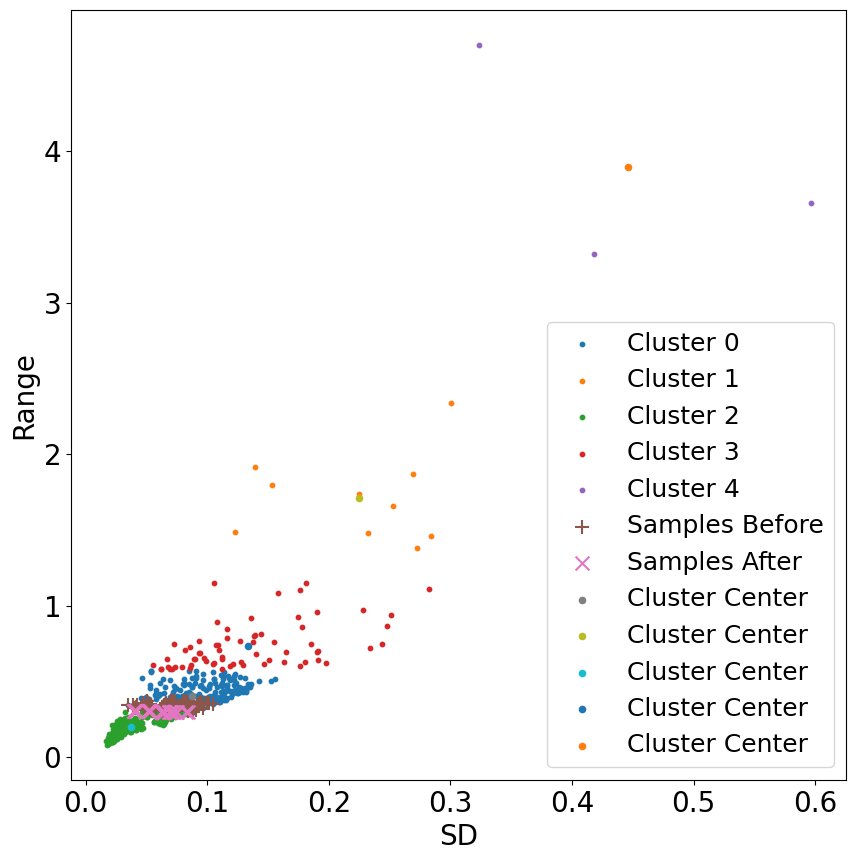

{0.11: 0.99}


In [18]:

max_perturbation = 0.11


adversarial_attack_results, data_with_perturbed_data2 = perturbe_samples_with_class(victim_model,from_cluster,from_cluster_datapoints, from_cluster_datapoints_indexes, target_cluster,target_cluster_datapoints,closest_k_instances_to_target_cluster, max_perturbation, step_size, save_file)


successful_cases = 0
for result in adversarial_attack_results:
    if len(result[3]) > 0:
        successful_cases += 1

attack_success = successful_cases / len(adversarial_attack_results)

attack_successes[max_perturbation] = attack_success
print(f"we have perturbed all samples in cluster {from_cluster} with perturbation Rate of {step_size} and a maximum perturbation of {max_perturbation} and had a success rate of {successful_cases * 100 / len(adversarial_attack_results)}%")

plot_result(adversarial_attack_results)


print(attack_successes)

In [29]:
adv_sample2 = pd.DataFrame(data_with_perturbed_data2, columns=['sd', 'range', 'delta', 'percentage_change', 'autocorrelation'])

adv_sample2["label"] = 1
adv_sample2["cluster"] = from_cluster

In [30]:
adv_sample2.to_csv("adv_sample2.csv")

In [ ]:
for i in range(5,100,2):
    max_perturbation = i/100
    
    if save_file:
        adversarial_attack_results, data_with_perturbed_data = perturbe_samples_with_class(victim_model,from_cluster,from_cluster_datapoints, from_cluster_datapoints_indexes, target_cluster,target_cluster_datapoints,closest_k_instances_to_target_cluster, max_perturbation, step_size, save_file)
    else:
        adversarial_attack_results, _ = perturbe_samples_with_class(victim_model,from_cluster,from_cluster_datapoints, None, target_cluster,target_cluster_datapoints,closest_k_instances_to_target_cluster, max_perturbation, step_size, save_file)

    
    
    successful_cases = 0
    for result in adversarial_attack_results:
        if len(result[3]) > 0:
            successful_cases += 1
    
    attack_success = successful_cases / len(adversarial_attack_results)

    attack_successes[max_perturbation] = attack_success
    print(f"we have perturbed all samples in cluster {from_cluster} with perturbation Rate of {step_size} and a maximum perturbation of {max_perturbation} and had a success rate of {successful_cases * 100 / len(adversarial_attack_results)}%")

    plot_result(adversarial_attack_results)


print(attack_successes)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(attack_successes.keys(), attack_successes.values())
plt.xlabel("Maximum Perturbation", fontsize=18)
plt.ylabel("Attack Success Rate", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()
